<a href="https://colab.research.google.com/github/SaleemAmu/plane-classification/blob/main/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  8590k      0  0:05:12  0:05:12 --:--:-- 23.8M


## Importation des librairies



In [70]:
import pathlib 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

#from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.model_selection import train_test_split

from PIL import Image

In [ ]:
DATA_DIR = pathlib.Path("dataset/data")

In [ ]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep=" ",
            names =["image_id", "manufacturer"],
            usecols =['image_id', "manufacturer"], # usecols for v1.4 compatibility
            dtype = {'image_id': str}, # id are not int but string
            ) 

In [ ]:
# Vérifcation des 
manufacturer_df["manufacturer"].value_counts(dropna=False)

Boeing         733
Airbus         434
Embraer        233
McDonnell      232
de             167
Canadair       134
Douglas        133
Cessna         133
British        133
Lockheed       102
Fokker         100
Dassault        67
Gulfstream      67
Beechcraft      67
Saab            67
Tupolev         66
ATR             66
Panavia         34
Antonov         34
Dornier         34
Yakovlev        34
Bombardier      33
Ilyushin        33
Fairchild       33
Piper           33
Cirrus          33
Eurofighter     33
Supermarine     33
Robin           33
Name: manufacturer, dtype: int64

In [ ]:
manufacturer_df.isna().sum()

image_id        0
manufacturer    0
dtype: int64

In [ ]:
assert manufacturer_df["image_id"].isna().sum() == 0, "Missing value in image_id"
assert manufacturer_df["manufacturer"].isna().sum() == 0, "Missing value in manufacturer"

# Vérifier si un caractère est présente dans un fichier


In [ ]:
!grep "," dataset/data/images_manufacturer_train.txt 

In [ ]:
# recherche de caractère T dans le fichier et n'affiche que les trois premières lignes
! grep "T" dataset/data/images_manufacturer_train.txt | head -3

0724121 ATR
0619697 ATR
2243949 ATR


In [ ]:
# wc: Compte le nombre d'éléments (-l: pour les lignes, -c: pour les caractères, -w: pour les word)
! grep "T" dataset/data/images_manufacturer_train.txt | wc -l

132


In [ ]:
!cut -f 1 -d ' ' dataset/data/images_manufacturer_train.txt | head

1025794
1340192
0056978
0698580
0450014
1042824
0894380
1427680
0817494
0716386


# Deal with N columns

## Make assumptions about number of spaces (here = 2) CETTE METHODE N EST PAS BONNE

In [ ]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep=" ",
            names =["image_id", "m1", "m2"],
            usecols =['image_id', "m1", "m2"], # usecols for v1.4 compatibility
            dtype = {'image_id': str}, # id are not int but string
            ) 

manufacturer_df["manufacturer"] = manufacturer_df["m1"] + ' ' + manufacturer_df["m2"] # PAS BON

manufacturer_df["manufacturer"].unique()

array([nan, 'British Aerospace', 'Lockheed Corporation',
       'Douglas Aircraft', 'McDonnell Douglas', 'de Havilland',
       'Lockheed Martin', 'Dassault Aviation', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Cirrus Aircraft'], dtype=object)

In [ ]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep="\t",
            names =["all"],
            dtype = {'all': str}, # id are not int but string
            ) 

# La fonction split() découpe une chaine de caractère

manufacturer_df["image_id"] = manufacturer_df["all"].apply(lambda x: x.split(' ')[0])

# La fonction "<car>".join(liste) concatène les éléments de liste en utilisant le séparateur <car>
manufacturer_df["manufacturer"] = manufacturer_df["all"].apply(lambda x: ' '.join(x.split(" ")[1:]))

In [ ]:
manufacturer_df["manufacturer"].unique()


array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [ ]:
# Construis une nouvelle variable qui permet de lier image_id et manufacturer

manufacturer_df["path"] = manufacturer_df["image_id"].apply(lambda x: pathlib.Path("dataset/data/images") / (x + ".jpg"))

In [ ]:
# On montre le contenu
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg


In [ ]:
def build_image_database(path, target):
    """Build a pandas dataframe with target class and access path to images.
   
    Parameters
    - - - - - -
    path (Path): path patern to read csv file containing images information.
    target (str): name of the target column.
   
    Returns
    - - - - -
    A pandas dataframe, including target class and path to image.
    """
   
   
    _df = pd.read_csv(path, sep='\t',
            names=['all'],
            dtype={'all': str} # ids are not int but string
            )

    # la fonction split() découpe sur une chaîne de charatères
    _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

    # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
    _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    # la colonne path contient le chemin d'accès à l'image
    _df['path'] = _df['image_id'].apply(lambda x:  pathlib.Path('dataset/data/images') / (x + '.jpg'))

    return _df.drop(columns=['all'])

In [ ]:
build_image_database(DATA_DIR / "images_manufacturer_train.txt","manufacturer").head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [ ]:
build_image_database(DATA_DIR / "images_family_train.txt","manufacturer").head(2)

,image_id,manufacturer,path
0,1025794,Boeing 707,dataset/data/images/1025794.jpg
1,1340192,Boeing 707,dataset/data/images/1340192.jpg


In [ ]:
manufacturer_df = build_image_database(DATA_DIR / "images_manufacturer_train.txt", "manufacturer")

In [ ]:
manufacturer_df = build_image_database(DATA_DIR / "images_manufacturer_train.txt", "manufacturer")

In [ ]:
# On récupère les chemins d'accès
manufacturer_df

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014,Boeing,dataset/data/images/0450014.jpg
...,...,...,...
3329,1577680,Yakovlev,dataset/data/images/1577680.jpg
3330,1826676,Yakovlev,dataset/data/images/1826676.jpg
3331,0472681,Yakovlev,dataset/data/images/0472681.jpg
3332,1597829,Yakovlev,dataset/data/images/1597829.jpg


In [ ]:
# La fonction:
# - prend un df (argument)
# - prend une ligne (row: argument, l'indice de la ligne))
# - prend une colonne (target : argument)
# - elle affiche la classe (la valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target):
  """ Show an image from an image database, with the associated class

  Parameter
  ---------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to displayed
  target (str): name of the target column

  Return
  ------
  None

"""
  assert target in df.columns, "Missing target column in dataframe"
  assert "path" in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))

  return

Boeing


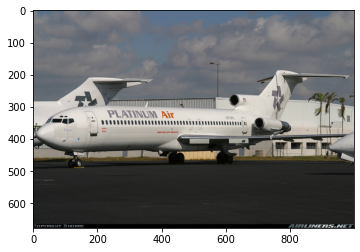

In [ ]:
show_image(manufacturer_df, 42, "manufacturer")

Boeing 707


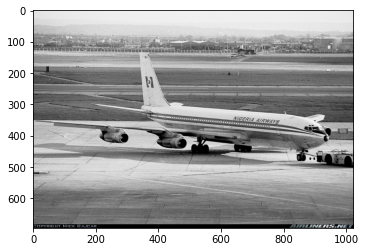

In [ ]:
show_image(build_image_database(DATA_DIR / "images_family_train.txt", "family"), 24, "family")

In [55]:
# Lire la taille d'un image

plt.imread(manufacturer_df.head(1)["path"].values[0]).shape

(695, 1024, 3)

In [58]:
# Récupérer les tailles d'image
manufacturer_df["image_shape"] = manufacturer_df["path"].apply(lambda p: plt.imread(p).shape)

In [64]:
# Charger et resizer les images
# Distribution du nombre de ligne
manufacturer_df["shape"].apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
845       1
1180      1
1149      1
885       1
482       1
Name: shape, Length: 404, dtype: int64

In [65]:
# Charger et resizer les images
# Distribution du nombre de colonne
manufacturer_df["shape"].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape, Length: 73, dtype: int64

In [66]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = IMAGE_WIDTH

In [75]:
# On redimensionne les images
def load_resize_image(path, height, width):
  """ Load an image and resize it to the target size.

  Parameter
  ---------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width

  Returns
  -------
  np.array containing resized image
  """

  return np.array(Image.open(path).resize((width, height)))

In [76]:
manufacturer_df.head(10).apply(lambda r: load_resize_image(r["path"], IMAGE_HEIGHT, IMAGE_WIDTH), axis = 1)

0    [[[219, 219, 219], [219, 219, 219], [219, 219,...
1    [[[212, 212, 212], [220, 220, 220], [196, 196,...
2    [[[131, 167, 205], [134, 168, 206], [134, 168,...
3    [[[48, 63, 68], [49, 64, 69], [50, 64, 69], [4...
4    [[[116, 160, 231], [116, 160, 232], [116, 161,...
5    [[[202, 202, 202], [202, 202, 202], [201, 201,...
6    [[[37, 93, 129], [37, 94, 129], [38, 94, 129],...
7    [[[171, 171, 171], [172, 172, 172], [172, 172,...
8    [[[192, 190, 195], [192, 190, 195], [193, 191,...
9    [[[107, 140, 156], [109, 141, 158], [110, 143,...
dtype: object

In [77]:
manufacturer_df["resized_image"] = manufacturer_df.apply(lambda r: load_resize_image(r["path"], IMAGE_HEIGHT, IMAGE_WIDTH), axis = 1)

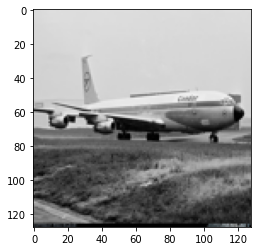

In [79]:
# Regarder une des images
plt.imshow(manufacturer_df.iloc[0,]['resized_image'])

In [49]:


#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



NameError: ignored